<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Named Entity Recognition
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
     Finetuning on CHIA (Albert)
  </div> 


  <div style="
      font-size: 15px; 
      line-height: 12px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Jean-baptiste AUJOGUE
  </div> 


  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [Albert finetuning](#albert) <br>
3. [Inference](#inference) <br>



#### Reference

- Hugginface full list of [tutorial notebooks](https://github.com/huggingface/transformers/tree/main/notebooks) (see also [here](https://huggingface.co/docs/transformers/main/notebooks#pytorch-examples))
- Huggingface [tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/token_classification.ipynb) on token classification
- Huggingface [course](https://huggingface.co/course/chapter7/2?fw=tf) on token classification
- Huggingface full list of [training scripts](https://github.com/huggingface/transformers/tree/main/examples/pytorch)
- Huggingface [training script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/token-classification/run_ner.py) on token classification
- Huggingface & Pytorch 2.0 [post](https://www.philschmid.de/getting-started-pytorch-2-0-transformers)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import random
import copy
import string

# data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
)
from transformers import DataCollatorForTokenClassification

# DL
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer,
    pipeline,
    set_seed,
)
import evaluate

# viz
from IPython.display import HTML

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Transformers settings

In [3]:
transformers.__version__

'4.27.1'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Custom paths & imports

In [5]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'chia', 'chia-ner')
path_to_logs = os.path.join(path_to_repo, 'logs', 'NER')
path_to_save_mlm = os.path.join(path_to_repo, 'saves', 'MLM')
path_to_save_ner = os.path.join(path_to_repo, 'saves', 'NER')
path_to_src  = os.path.join(path_to_repo, 'src')

In [6]:
sys.path.insert(0, path_to_src)

In [7]:
from nlptools.ner.preprocessing import tokenize_and_align_categories, create_labels
from nlptools.ner.metrics import compute_metrics, compute_metrics_finegrained
from nlptools.ner.postprocessing import parse_trf_ner_output, remove_entity_overlaps, correct_entity_boundaries
from nlptools.ner.visualization import render_ner_as_html

#### Constants

We use these variables to build the directories used to collect the outputs of this notebook:

- Finetuning logs will be stored at `logs/NER/final_model_name/run_name`
- Finetuned model will be stored at `saves/NER/final_model_name/run_name`


In [8]:
run_name = 'notebook'
dataset_name = 'chia'
hub_model_name = 'albert-base-v2'
base_model_name = 'albert'
final_model_name = '{}-{}'.format(base_model_name, dataset_name)

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

This section is dedicated to loading the dataset, converting it into instances of the `datasets.Dataset` class, and subsequently apply tokenization. For simplicity we load the entire data into RAM, but reading data directly from disk or distant sources remains possible, see the ist of options at Huggingface [dataset loading](https://huggingface.co/docs/datasets/loading) documentation.

Note that the class we use here is different from the `torch.utils.data.Dataset` class. 

## 1.1 Load BIO corpus

[Table of content](#TOC)

In [9]:
df_bio = pd.read_csv(os.path.join(path_to_data, 'chia_bio.tsv'), sep = "\t")

df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT00050349_exc,NCT00050349_exc_0,Patients,O
1,NCT00050349_exc,NCT00050349_exc_0,with,O
2,NCT00050349_exc,NCT00050349_exc_0,symptomatic,B-Qualifier
3,NCT00050349_exc,NCT00050349_exc_0,,O
4,NCT00050349_exc,NCT00050349_exc_0,CNS,B-Condition
5,NCT00050349_exc,NCT00050349_exc_0,metastases,I-Condition
6,NCT00050349_exc,NCT00050349_exc_0,,O
7,NCT00050349_exc,NCT00050349_exc_0,or,O
8,NCT00050349_exc,NCT00050349_exc_0,leptomeningeal,B-Condition
9,NCT00050349_exc,NCT00050349_exc_0,involvement,I-Condition


For conveniance we create an instance of `ClassLabel` that keeps the class name - class index alignment in a single object :

In [10]:
class_labels = sorted(list(set(df_bio.Category.unique())))
class_labels = ClassLabel(names = class_labels)

In [11]:
label2id = class_labels._str2int
id2label = {i: l for l, i in label2id.items()}

## 1.2 Generate train / valid / test datasets

[Table of content](#TOC)

We split the dataset of 1000 trials into 800 trials for training, 100 trials for validation and 100 trials for testing

In [12]:
def get_item_list(df, grp_col, item_col):
    return df.groupby(grp_col).apply(lambda g: g[item_col].tolist()).tolist()



def convert_dataframe_to_dataset(df_bio):
    data = {
        'ids': df_bio.Sequence_id.unique().tolist(),
        'mentions': get_item_list(df_bio, 'Sequence_id', 'Mention'),
        'categories': get_item_list(df_bio, 'Sequence_id', 'Category'),
    }
    return data

In [13]:
ids_bio = sorted(list(set(df_bio.Id.apply(lambda i: i.split('_')[0]))))

ids_trn, ids_dev = train_test_split(ids_bio, train_size = 0.8, random_state = 13, shuffle = True)
ids_dev, ids_tst = train_test_split(ids_dev, train_size = 0.5, random_state = 13, shuffle = True)

len(ids_bio), len(ids_trn), len(ids_dev), len(ids_tst)

(1000, 800, 100, 100)

In [14]:
df_trn = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_trn)]
df_dev = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_dev)]
df_tst = df_bio[df_bio.Id.apply(lambda i: i.split('_')[0]).isin(ids_tst)]

The dataset and its 3 splits are converted into `datasets.Dataset` instances:

In [15]:
dict_bio = convert_dataframe_to_dataset(df_bio)
dict_trn = convert_dataframe_to_dataset(df_trn)
dict_dev = convert_dataframe_to_dataset(df_dev)
dict_tst = convert_dataframe_to_dataset(df_tst)

After performing the train/dev/test split, we wrap all datasets into a `datasets.DatasetDict`, so that subsequent operations on this data will be performed on this single object:

In [16]:
features = Features({
    'ids': Value(dtype = 'string'), 
    'mentions': Sequence(Value(dtype = 'string')), 
    'categories': Sequence(Value(dtype = 'string')),
})

In [17]:
raw_datasets = DatasetDict({
    'trn': Dataset.from_dict(dict_trn, features = features),
    'dev': Dataset.from_dict(dict_dev, features = features),
    'tst': Dataset.from_dict(dict_tst, features = features),
    'all': Dataset.from_dict(dict_bio, features = features),
})

<Axes: ylabel='Frequency'>

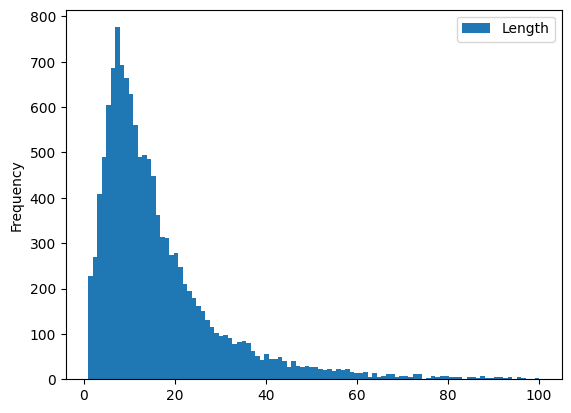

In [18]:
# distribution of lengths
lengths = [len(ts) for ts in raw_datasets['all']['mentions']]
lengths = [l for l in lengths if l<= 100]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100)

We can inspect the first item of the test dataset:

In [19]:
for k, v in raw_datasets['tst'][0].items():
    print(k, ':', v)

ids : NCT00122070_exc_0
mentions : ['Are', 'pregnant', ' ', 'or', 'lactating', '.']
categories : ['O', 'B-Condition', 'O', 'O', 'B-Condition', 'O']


## 1.3 Apply model-specific tokenization

[Table of content](#TOC)


In [20]:
tokenizer_path = os.path.join(path_to_save_mlm, base_model_name, 'tokenizer')

try:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    print('Tokenizer loaded from local checkpoint.')
except:
    tokenizer = AutoTokenizer.from_pretrained(hub_model_name)
    tokenizer.save_pretrained(tokenizer_path)
    print('Tokenizer downloaded from Huggingface model hub.')

Tokenizer loaded from local checkpoint.


The tokenizer has an `encode` method that process an input string and outputs a sequence of token ids (notice that this method expects one or _two_ input strings as argument):

In [21]:
tokenizer.encode('I like NLP very much 😁', 'and Math too !')

[2, 31, 101, 13, 103, 5478, 253, 212, 13, 1, 3, 17, 5057, 266, 13, 187, 3]

The tokenizer has a subsequent `decode` method that process a sequence of token ids and returns a reformed string (with some loss due to string normalization and presence of unknown words/symbols):

In [22]:
tokenizer.decode([2, 31, 101, 13, 103, 5478, 253, 212, 13, 1, 3, 17, 5057, 266, 13, 187, 3])

'[CLS] i like nlp very much <unk>[SEP] and math too![SEP]'

The `__call__` method of the tokenizer provides a more complete output. It can process a sentence that was already split into words as follows:

In [23]:
words  = raw_datasets['tst']['mentions'][0]

print(words)
print(tokenizer(words, is_split_into_words = True).tokens())

['Are', 'pregnant', ' ', 'or', 'lactating', '.']
['[CLS]', '▁are', '▁pregnant', '▁or', '▁lac', 't', 'ating', '▁', '.', '[SEP]']


As we can see, the tokenizer added the special tokens used by the model ([CLS] at the beginning and [SEP] at the end) and further tokenized the long and technical word 'lactating' into 3 subwords, '▁lac', 't', 'ating'. This introduces a mismatch between our inputs and the labels: the list of labels has only 6 elements, whereas our input now has 10 tokens. Accounting for the special tokens is easy (we know they are at the beginning and the end), but we also need to make sure we align all the labels with the proper words.

To mitigate this, we need to perform the following operations:

- transform the `mentions` column of the datasets by tokenizing further each word into sub-word units
- transform the `categories` column of the dataset to align with newly created tokens


This is done by the `tokenize_and_align_categories` function below.

In [24]:
B_I_mapping = {l: 'I'+l[1:] for l in class_labels.names if l.startswith('B-')}
B_I_mapping

{'B-Condition': 'I-Condition',
 'B-Device': 'I-Device',
 'B-Drug': 'I-Drug',
 'B-Measurement': 'I-Measurement',
 'B-Observation': 'I-Observation',
 'B-Person': 'I-Person',
 'B-Procedure': 'I-Procedure',
 'B-Qualifier': 'I-Qualifier',
 'B-Temporal': 'I-Temporal',
 'B-Value': 'I-Value'}

In [25]:
tokenized_datasets = raw_datasets.map(
    function = lambda examples: tokenize_and_align_categories(tokenizer, examples, B_I_mapping), 
    batched  = True,
)

Additional `tokens`, `token_categories` and `input_ids` columns are available in the newly formed dataset:

In [26]:
for k, v in tokenized_datasets['tst'][0].items():
    print(k, ':', v)

ids : NCT00122070_exc_0
mentions : ['Are', 'pregnant', ' ', 'or', 'lactating', '.']
categories : ['O', 'B-Condition', 'O', 'O', 'B-Condition', 'O']
input_ids : [2, 50, 5951, 54, 8213, 38, 1880, 13, 9, 3]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tokens : ['[CLS]', '▁are', '▁pregnant', '▁or', '▁lac', 't', 'ating', '▁', '.', '[SEP]']
token_categories : [None, 'O', 'B-Condition', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'O', 'O', None]


<Axes: ylabel='Frequency'>

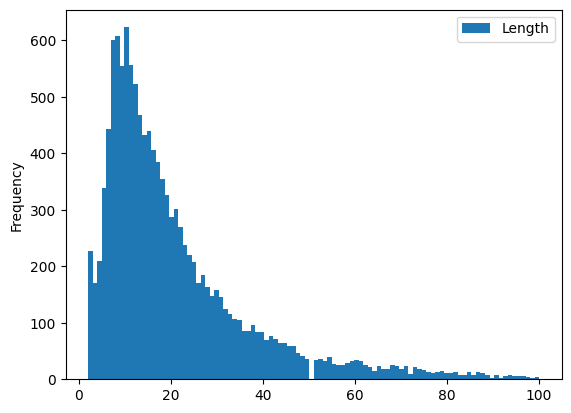

In [27]:
# distribution of lengths
lengths = [len(ts) for ts in tokenized_datasets['all']['input_ids']]
lengths = [l for l in lengths if l<= 100]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100)

## 1.4 Map categories to integers

[Table of content](#TOC)


In [28]:
tokenized_datasets = tokenized_datasets.map(
    function = lambda examples: create_labels(examples, class_labels), 
    batched  = True,
)

A new `labels` column is available in the dataset, and corresponds to the integer index, in the `class_labels` object, of the category of each token (or -100 if the category is None) :

In [29]:
for k, v in tokenized_datasets['tst'][0].items():
    print(k, ':', v)

ids : NCT00122070_exc_0
mentions : ['Are', 'pregnant', ' ', 'or', 'lactating', '.']
categories : ['O', 'B-Condition', 'O', 'O', 'B-Condition', 'O']
input_ids : [2, 50, 5951, 54, 8213, 38, 1880, 13, 9, 3]
token_type_ids : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tokens : ['[CLS]', '▁are', '▁pregnant', '▁or', '▁lac', 't', 'ating', '▁', '.', '[SEP]']
token_categories : [None, 'O', 'B-Condition', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'O', 'O', None]
labels : [-100, 20, 0, 20, 0, 10, 10, 20, 20, -100]


In [30]:
max([len(c) for c in tokenized_datasets['trn']['input_ids']])

512

### Remarks

- By contrast to the generic BIO annotated data, this new dataset depends on the tokenizer, and is therefore _model-specific_.
- The names `input_ids`, `token_type_ids`,  `attention_mask` and `labels` present in the dataset are expected by the NER model and trainer, and can't be changed.

<a id="albert"></a>

# 2. Model finetuning

[Table of content](#TOC)

## 2.1 Evaluation metric

[Table of content](#TOC)

During finetuning of our model, we periodically compute performance metrics for the NER task. This is done using the [seqeval](https://github.com/chakki-works/seqeval) utility package, whose behavior is briefly presented below.

In [31]:
metric = evaluate.load("seqeval")

Let's see how this metric works:

In [32]:
tokens = tokenized_datasets['tst'][0]['tokens'][1:-1]
labels = tokenized_datasets['tst'][0]['token_categories'][1:-1]

predictions = labels.copy()
predictions[4] = "B-Condition"
# predictions[6] = "I-Condition"

print('tokens :', tokens)
print('labels :', labels)
print('prediction: ', predictions)

metric.compute(predictions = [predictions], references = [labels])

tokens : ['▁are', '▁pregnant', '▁or', '▁lac', 't', 'ating', '▁', '.']
labels : ['O', 'B-Condition', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'O', 'O']
prediction:  ['O', 'B-Condition', 'O', 'B-Condition', 'B-Condition', 'I-Condition', 'O', 'O']


{'Condition': {'precision': 0.3333333333333333,
  'recall': 0.5,
  'f1': 0.4,
  'number': 2},
 'overall_precision': 0.3333333333333333,
 'overall_recall': 0.5,
 'overall_f1': 0.4,
 'overall_accuracy': 0.875}

The accuracy, precision, recall and f1 score is computed for each category (e.g. any term appearing after a prefix of the form 'B-', 'I-', 'E-', 'S-') encountered in the batch of items to evaluate, along with overall scores.

This metric takes the lists of labels as strings, not integers, so in order to compute performance scores during finetuning, we will need to fully decode the predictions and labels before passing them to the metric. All is cast into the `compute_metrics_finegrained` function, which is passed in argument to the trainer.

## 2.2 BERT model for Token Classification

[Table of content](#TOC)

Downloaded checkpoints are by default stored in HF standard cache, which is in our case `C:\Users\me\.cache\huggingface\hub`. This directory can be changed with the `cache_dir` parameter.

In [33]:
# make model creation & training deterministic
set_seed(42)

In [34]:
base_model_path = os.path.join(path_to_save_mlm, base_model_name, 'model')

try:
    model = AutoModelForTokenClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)
    print('Model loaded from local checkpoint.')
except:
    model = AutoModelForMaskedLM.from_pretrained(hub_model_name)
    model.save_pretrained(base_model_path)
    model = AutoModelForTokenClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)
    print('Model downloaded from Huggingface model hub.')

Some weights of the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transformers for NLP\saves\MLM\albert\model were not used when initializing AlbertForTokenClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transform

Model loaded from local checkpoint.


In [35]:
model.num_parameters()

11109141

In [37]:
model = model.to(device)
model = model.train()

## 2.3 Run finetuning on train-valid-test split

[Table of content](#TOC)

This finetuning step is meant to compute and log quality metrics as the finetuning goes. It is run on the train-valid-test split, and consequently the fintuning doesn't benefit from all the available data. To run finetuning on all data, jump to next section

In [38]:
batch_size = 6

In [42]:
args = TrainingArguments(
    # training args
    learning_rate = 2e-5,
    weight_decay = 1e-4,
    num_train_epochs = 4,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    bf16 = True,
    torch_compile = False,
    optim = "adamw_torch_fused",
    # logging args
    output_dir = os.path.join(path_to_save_ner, '_checkpoints'),
    logging_dir = os.path.join(path_to_logs, final_model_name, run_name),
    evaluation_strategy = 'steps',
    save_strategy = 'no',
    logging_steps = 500,
    report_to = ['tensorboard'],
    log_level = 'warning',
)

In [43]:
trainer = Trainer(
    model,
    args,
    data_collator = DataCollatorForTokenClassification(tokenizer),
    train_dataset = tokenized_datasets['trn'],
    eval_dataset  = tokenized_datasets['dev'],
    compute_metrics = lambda p: compute_metrics_finegrained(p, metric, class_labels.names),
)

Remarks:

- The `data_collator` is the object used to batch and pad elements of the training & evaluation datasets.
- Tensor precision is by default `float32`, but other precision are available when using recent GPUs or CPU, see Huggingface post on [floating data types](https://huggingface.co/docs/transformers/v4.15.0/performance#floating-data-types).

In [44]:
trainer.train()

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Condition precision,Condition recall,Condition f1,Device precision,Device recall,Device f1,Drug precision,Drug recall,Drug f1,Measurement precision,Measurement recall,Measurement f1,Observation precision,Observation recall,Observation f1,Person precision,Person recall,Person f1,Procedure precision,Procedure recall,Procedure f1,Qualifier precision,Qualifier recall,Qualifier f1,Temporal precision,Temporal recall,Temporal f1,Value precision,Value recall,Value f1
500,1.042400,0.828838,0.482200,0.526216,0.503247,0.767393,0.547292,0.724665,0.623612,0.000000,0.000000,0.000000,0.558081,0.677914,0.612188,0.530806,0.486957,0.507937,0.833333,0.039370,0.075188,0.911392,0.486486,0.634361,0.342803,0.615646,0.440389,0.319392,0.227642,0.265823,0.260223,0.255474,0.257827,0.515823,0.515823,0.515823
1000,0.743700,0.720225,0.558992,0.553696,0.556331,0.785523,0.630952,0.709369,0.667867,0.071429,0.083333,0.076923,0.638655,0.699387,0.667643,0.568889,0.556522,0.562637,0.500000,0.031496,0.059259,0.730496,0.695946,0.712803,0.431319,0.534014,0.477204,0.390805,0.276423,0.323810,0.307692,0.277372,0.291747,0.666667,0.664557,0.665610
1500,0.679500,0.683127,0.535560,0.627922,0.578075,0.792519,0.609968,0.737094,0.667532,0.062500,0.027778,0.038462,0.592771,0.754601,0.663968,0.516667,0.673913,0.584906,0.347826,0.062992,0.106667,0.785714,0.743243,0.763889,0.507289,0.591837,0.546311,0.328244,0.466125,0.385218,0.387500,0.452555,0.417508,0.618529,0.718354,0.664714
2000,0.622700,0.671939,0.553627,0.614656,0.582548,0.800748,0.575545,0.782983,0.663426,0.230769,0.250000,0.240000,0.604878,0.760736,0.673913,0.603448,0.608696,0.606061,0.458333,0.086614,0.145695,0.718750,0.777027,0.746753,0.487730,0.540816,0.512903,0.356401,0.279133,0.313070,0.435252,0.441606,0.438406,0.661677,0.699367,0.680000
2500,0.558300,0.631771,0.559226,0.620341,0.588200,0.796788,0.618789,0.761950,0.682948,0.282609,0.361111,0.317073,0.605042,0.662577,0.632504,0.584000,0.634783,0.608333,0.294118,0.039370,0.069444,0.755102,0.750000,0.752542,0.465608,0.598639,0.523810,0.368700,0.376694,0.372654,0.434211,0.481752,0.456747,0.658046,0.724684,0.689759
3000,0.571900,0.625501,0.568016,0.638345,0.601130,0.803960,0.679034,0.752390,0.713832,0.333333,0.388889,0.358974,0.663818,0.714724,0.688331,0.592308,0.669565,0.628571,0.250000,0.062992,0.100629,0.741722,0.756757,0.749164,0.447689,0.625850,0.521986,0.348387,0.439024,0.388489,0.449848,0.540146,0.490879,0.611732,0.693038,0.649852
3500,0.520300,0.654235,0.555556,0.649084,0.598689,0.799560,0.613166,0.792543,0.691410,0.388889,0.388889,0.388889,0.678571,0.757669,0.715942,0.537367,0.656522,0.590998,0.297872,0.110236,0.160920,0.763158,0.783784,0.773333,0.489971,0.581633,0.531882,0.319290,0.390244,0.351220,0.464968,0.532847,0.496599,0.631728,0.705696,0.666667
4000,0.447600,0.600694,0.583264,0.662666,0.620435,0.815314,0.657051,0.783939,0.714908,0.340909,0.416667,0.375000,0.663158,0.773006,0.713881,0.564885,0.643478,0.601626,0.243243,0.070866,0.109756,0.801471,0.736486,0.767606,0.493573,0.653061,0.562225,0.385542,0.433604,0.408163,0.480114,0.616788,0.539936,0.670659,0.708861,0.689231
4500,0.443900,0.624476,0.579545,0.676563,0.624308,0.811925,0.676710,0.794455,0.730871,0.300000,0.416667,0.348837,0.596330,0.797546,0.682415,0.635193,0.643478,0.639309,0.271605,0.173228,0.211538,0.761006,0.817568,0.788274,0.477401,0.574830,0.521605,0.363436,0.447154,0.400972,0.482940,0.671533,0.561832,0.709375,0.718354,0.713836
5000,0.436300,0.604508,0.571072,0.650979,0.608413,0.812673,0.667502,0.763862,0.712439,0.377778,0.472222,0.419753,0.644836,0.785276,0.708160,0.590551,0.652174,0.619835,0.202532,0.125984,0.155340,0.775510,0.770270,0.772881,0.454039,0.554422,0.499234,0.354839,0.447154,0.395683,0.462963,0.547445,0.501672,0.675439,0.731013,0.702128


TrainOutput(global_step=6732, training_loss=0.5380558233776761, metrics={'train_runtime': 512.1331, 'train_samples_per_second': 78.847, 'train_steps_per_second': 13.145, 'total_flos': 93310281261864.0, 'train_loss': 0.5380558233776761, 'epoch': 4.0})

In [45]:
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['tst'], metric_key_prefix = 'test')

In [46]:
for k, v in test_results.items():
    print(str(k) + ' ' + '-'*(30 - len(k)) + ' {:2f}'.format(100*v))

test_loss --------------------- 62.725490
test_precision ---------------- 60.949612
test_recall ------------------- 65.299766
test_f1 ----------------------- 63.049743
test_accuracy ----------------- 82.283105
test_Condition precision ------ 69.387755
test_Condition recall --------- 76.527331
test_Condition f1 ------------- 72.782875
test_Device precision --------- 42.222222
test_Device recall ------------ 52.777778
test_Device f1 ---------------- 46.913580
test_Drug precision ----------- 70.637119
test_Drug recall -------------- 73.275862
test_Drug f1 ------------------ 71.932299
test_Measurement precision ---- 58.997050
test_Measurement recall ------- 64.308682
test_Measurement f1 ----------- 61.538462
test_Observation precision ---- 23.684211
test_Observation recall ------- 17.647059
test_Observation f1 ----------- 20.224719
test_Person precision --------- 84.768212
test_Person recall ------------ 80.503145
test_Person f1 ---------------- 82.580645
test_Procedure precision ------ 52

In [47]:
del model

torch.cuda.empty_cache()

## 2.4 Run finetuning on all data

[Table of content](#TOC)

In [48]:
# make model creation & training deterministic
set_seed(42)

In [49]:
base_model_path = os.path.join(path_to_save_mlm, base_model_name, 'model')

model = AutoModelForTokenClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)

Some weights of the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transformers for NLP\saves\MLM\albert\model were not used when initializing AlbertForTokenClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transform

In [50]:
model = model.to(device)
model = model.train()

In [51]:
batch_size = 6

In [52]:
args = TrainingArguments(
    # training args
    learning_rate = 2e-5,
    weight_decay = 1e-4,
    num_train_epochs = 4,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    bf16 = True,
    torch_compile = False,
    optim = "adamw_torch_fused",
    # logging args
    output_dir = os.path.join(path_to_save_ner, '_checkpoints'),
    evaluation_strategy = 'no',
    save_strategy = 'no',
)

In [53]:
metric = evaluate.load("seqeval")

In [54]:
trainer = Trainer(
    model,
    args,
    data_collator = DataCollatorForTokenClassification(tokenizer),
    train_dataset = tokenized_datasets['all'],
)

In [55]:
trainer.train()

Step,Training Loss
500,1.037500
1000,0.748900
1500,0.677200
2000,0.676600
2500,0.609400
3000,0.540400
3500,0.520700
4000,0.533400
4500,0.477900
5000,0.441100


TrainOutput(global_step=8424, training_loss=0.5213984827257176, metrics={'train_runtime': 559.7286, 'train_samples_per_second': 90.279, 'train_steps_per_second': 15.05, 'total_flos': 115325300542644.0, 'train_loss': 0.5213984827257176, 'epoch': 4.0})

In [56]:
model = model.to('cpu')

In [57]:
tokenizer.save_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'tokenizer'))
model.save_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'model'))

<a id="inference"></a>

# 3. Inference

[Table of content](#TOC)

In [58]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'tokenizer'))
model = AutoModelForTokenClassification.from_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'model'))

In [59]:
ner = pipeline(
    task = 'ner', 
    model = model, 
    tokenizer = tokenizer,
    framework = 'pt',
    aggregation_strategy = 'simple',
)

In [60]:
sent = 'Radiologic examination of chest'


df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [61]:
sent = 'Participants with at least two of the following: serum M-protein >= 0.5 g/dL, urine M-protein >=200 mg/24 hours, an involved FLC assay >=100 mg/L, and a serum FLC ratio <0.26 or a serum FLC ratio  >1.65'


df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [62]:
sent = 'Participants with at least two of the following: Serum M-protein >= 0.5 g/dL measured using serum protein immunoelectrophoresis, Urine M-protein >=200 mg/24 hours measured using urine protein immunoelectrophoresis, Serum free light chain (FLC) assay with an involved FLC assay >=100 mg/L, and a serum FLC ratio < 0.26 or a serum FLC ratio  > 1.65'


df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [63]:
sent = 'Polyneuropathy of other causes, including but not limited to hereditary demyelinating neuropathies, neuropathies secondary to infection or systemic disease, diabetic neuropathy, drug- or toxin-induced neuropathies, multifocal motor neuropathy, monoclonal gammopathy of uncertain significance, lumbosacral radiculoplexus neuropathy, pure sensory CIDP and acquired demyelinating symmetric (DADS) neuropathy (also known as distal CIDP).'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [64]:
sent = 'Adults and adolescent patients with a physician diagnosis of asthma ' +\
    'for ≥12 months, based on the Global Initiative for Asthma (GINA) 2014 Guidelines ' +\
    'and the followingcriteria: A) Existing treatment with medium to high dose ICS ' +\
    '(≥250 mcg of fluticasone propionate twice daily or equipotent ICS daily dosage ' +\
    'to a maximum of 2000 mcg/day of fluticasone propionate or equivalent) in combination ' +\
    'with a second controller (eg, LABA, LTRA) for at least 3 months with a stable dose ≥1 ' +\
    'month prior to Visit 1.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [65]:
sent = 'Biologics treatment: Cell-depleting agents, eg. Rituximab Drug within 6 months before baseline or until lymphocyte count returns to normal, Other biologics: within 5 half-lives or 16 weeks prior baseline.'

df_ents = parse_trf_ner_output(ner(sent))
df_ents = correct_entity_boundaries(sent, df_ents)
df_ents = remove_entity_overlaps(df_ents)
HTML(render_ner_as_html(sent, df_ents))

In [70]:
sents = '''Active hepatitis or patients with positive HBsAg, or patients with positive HBcAb plus positive HBV DNA, or positive HCV antibody (confirmed with presence of HCV RNA if needed) at screening.

History of alcohol or drug abuse within 2 years of the screening visit.

History of HIV infection or positive HIV serology at screening.

History of malignancy within 5 years before screening, except completely treated cervix carcinoma, completely treated and resolved non-metastatic squamous or basal cell carcinoma of the skin.

Infection requires systemic antibiotics, antivirals, antiparasitics, antiprotozoals, antifungals treatment within 2 weeks before baseline, superficial skin infections within 1 week before baseline visit.

Initiation AD treatment with prescription moisturizers or moisturizers containing  additives such as ceramide, hyaluronic acid, urea, or filaggrin degradation products during the screening period.

Known or suspected history of immunosuppression, including history of invasive opportunistic infections, despite infection resolution, or unusually frequent, recurrent, or prolonged infections.
'''
df_list = []
html = ''
for sent in sents.split('\n'):
    if sent.strip():
        ents = parse_trf_ner_output(ner(sent))
        ents = correct_entity_boundaries(sent, ents)
        ents = remove_entity_overlaps(ents)
        df_list.append(ents)
        html += render_ner_as_html(sent, ents)

df_ents = pd.concat(df_list, ignore_index = True)
HTML(html)

[Table of content](#TOC)